# Recommendation System

## Obtain the movie lens dataset from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip It contains 100,000 ratings applied to 9,000 movies by 600 users. Refer the readme file in the dataset.

In [1]:
#Download data files from given URL and extract them
import requests, zipfile, io
r = requests.get("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall(".")

## Task 1: Read the dataset files and load them in appropriate data structure and display top-5 rows in each of them ( 2 marks )

In [2]:
import pandas as pd
from math import pow, sqrt
import numpy as np

links=pd.read_csv("ml-latest-small/links.csv")
movies=pd.read_csv("ml-latest-small/movies.csv")
ratings=pd.read_csv("ml-latest-small/ratings.csv")
tags=pd.read_csv("ml-latest-small/tags.csv")

links.head()


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## Task 2: Print CDF plot of average ratings given by users. X-axis is value of average ratings, and Y-axis is the cumulative frequency ( 2 marks )

In [6]:
ratings.groupby('rating')['rating'].agg('count') 

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: rating, dtype: int64

Text(0, 0.5, 'Cumulative Frequency')

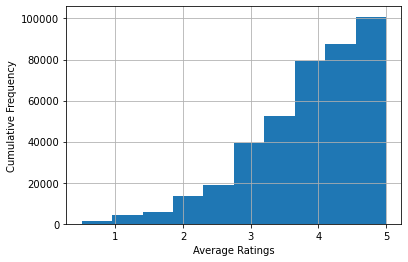

In [7]:
axarr = ratings.rating.hist( cumulative = True )
axarr.set_xlabel("Average Ratings")
axarr.set_ylabel("Cumulative Frequency")

## Task 3: Arrange users in increasing order of the average ratings they have given. Select a user (X1) at 30 percentile and print the movies and corresponding movies ratings given by X1 ( 2 marks )

In [8]:
summary = ratings.groupby('userId')['rating'].agg('mean').rename('avg_rating').sort_values()
pecentile30rating =  np.percentile(summary,30,interpolation="nearest") 
X1= summary[summary == pecentile30rating].index[0] 

In [9]:
print("30th Percentile User's UserId is %d and this user's movies are: "%X1)
movie_ratings =movies.merge(ratings,on = 'movieId',how = 'inner')
display(movie_ratings [movie_ratings.userId == X1][["title","rating"]])

30th Percentile User's UserId is 34 and this user's movies are: 


,title,rating
620,GoldenEye (1995),5.0
2862,From Dusk Till Dawn (1996),3.5
3398,Braveheart (1995),0.5
3986,Bad Boys (1995),1.0
4725,Desperado (1995),3.0
...,...,...
78603,Ong-Bak: The Thai Warrior (Ong Bak) (2003),5.0
79095,Appleseed (Appurushîdo) (2004),3.0
79233,Hitch (2005),2.0
82245,Hard Candy (2005),4.5


## Task 4: Find top-5 users "similar" to this user (X1) based on movie ratings. Clearly mention (in comments) your criteria to compute similarity. ( 4 marks )

In [10]:
# Getting the rating given by a user to a movie.
def get_rating_(userid,movieid):
    return (ratings.loc[(ratings.userId==userid) & (ratings.movieId == movieid),'rating'].iloc[0])
# Getting the list of all movie ids the specified user has rated.
def get_movieids_(userid):
    return (ratings.loc[(ratings.userId==userid),'movieId'].tolist())
# Getting the movie titles against the movie id.
def get_movie_title_(movieid):
    return (movies.loc[(movies.movieId == movieid),'title'].iloc[0])

def pearson_correlation_score(user1,user2):
    '''
    user1 & user2 : user ids of two users between which similarity score is to be calculated.
    '''
    # A list of movies watched by both the users.
    both_watch_count = []
    
    # Finding movies watched by both the users.
    for element in ratings.loc[ratings.userId==user1,'movieId'].tolist():
        if element in ratings.loc[ratings.userId==user2,'movieId'].tolist():
            both_watch_count.append(element)
    
    # Returning '0' correlation for bo common movies.
    if len(both_watch_count) == 0 :
        return 0
    
    # Calculating Co-Variances.
    rating_sum_1 = sum([get_rating_(user1,element) for element in both_watch_count])
    rating_sum_2 = sum([get_rating_(user2,element) for element in both_watch_count])
    rating_squared_sum_1 = sum([pow(get_rating_(user1,element),2) for element in both_watch_count])
    rating_squared_sum_2 = sum([pow(get_rating_(user2,element),2) for element in both_watch_count])
    product_sum_rating = sum([get_rating_(user1,element) * get_rating_(user2,element) for element in both_watch_count])
    
    # Returning pearson correlation between both the users.
    numerator = product_sum_rating - ((rating_sum_1 * rating_sum_2) / len(both_watch_count))
    denominator = sqrt((rating_squared_sum_1 - pow(rating_sum_1,2) / len(both_watch_count)) * (rating_squared_sum_2 - pow(rating_sum_2,2) / len(both_watch_count)))
    
    # Handling 'Divide by Zero' error.
    if denominator == 0:
        return 0
    return numerator/denominator

def most_similar_users_(user1,number_of_users):
    '''
    user1 : Targeted User
    number_of_users : number of most similar users you want to user1.
    metric : metric to be used to calculate inter-user similarity score. ('pearson' or else)
    '''
    # Getting distinct user ids.
    userIds = ratings.userId.unique().tolist()
    
    # Getting similarity score between targeted and every other suer in the list(or subset of the list).
    similarity_score = [(pearson_correlation_score(user1,nth_user),nth_user) for nth_user in userIds[:100] if nth_user != user1]
     
    # Sorting in descending order.
    similarity_score.sort()
    similarity_score.reverse()
    
    # Returning the top most 'number_of_users' similar users. 
    return similarity_score[:number_of_users]


<b>Pearson Correlation Similarity Measure</b>: Calculating similarity scores based on the euclidean distance have an inherent problem. We do not have a threshold to decide how much distance between two users is to be considered for calculating whether the users are close enough or far enough. On the other side, this problem is resolved by pearson correlation method as it always returns a value between -1 & 1 which clearly provides us with the boundaries for closeness as we prefer

In [11]:
recos = most_similar_users_(X1,5)
print("User's similar to user %d based on ratings are: "%X1)
print("USER_ID   SIMILARITY SCORE")
for (similarity, userId) in recos:
    print("%7d    %0.2f"%(userId,similarity)   )

User's similar to user 34 based on ratings are: 
USER_ID   SIMILARITY SCORE
     29    1.00
     44    1.00
      2    1.00
     40    0.96
     70    0.87


## Task 5: Recommend top-10 movies to the user (X1) we have selected. ( 2 marks )

In [12]:
def get_recommendation_(userid):
    userIds = ratings.userId.unique().tolist()
    total = {}
    similariy_sum = {}
    
    # Iterating over subset of user ids.
    for user in userIds[:100]:
        
        # not comparing the user to itself (obviously!)
        if user == userid:
            continue
        
        # Getting similarity score between the users.
        score = pearson_correlation_score(userid,user)
        
        # not considering users having zero or less similarity score.
        if score <= 0:
            continue
        
        # Getting weighted similarity score and sum of similarities between both the users.
        for movieid in get_movieids_(user):
            # Only considering not watched/rated movies
            if movieid not in get_movieids_(userid) or get_rating_(userid,movieid) == 0:
                total[movieid] = 0
                total[movieid] += get_rating_(user,movieid) * score
                similariy_sum[movieid] = 0
                similariy_sum[movieid] += score
    
    # Normalizing ratings
    ranking = [(tot/similariy_sum[movieid],movieid) for movieid,tot in total.items()]
    ranking.sort()
    ranking.reverse()
    
    # Getting movie titles against the movie ids.
    recommendations = [get_movie_title_(movieid) for score,movieid in ranking]
    return recommendations[:10]

In [13]:
print('Recommended Top-10 movies for user %d are: '%X1)
for movie in  get_recommendation_(X1):
    print(movie)

Recommended Top-10 movies for user 34 are: 
Zootopia (2016)
10 Cloverfield Lane (2016)
The Martian (2015)
The Jinx: The Life and Deaths of Robert Durst (2015)
Ant-Man (2015)
Avengers: Age of Ultron (2015)
Mad Max: Fury Road (2015)
Wild Tales (2014)
Big Hero 6 (2014)
Guardians of the Galaxy (2014)
